<a href="https://colab.research.google.com/github/t080/jawiki-headline-dataset/blob/master/preprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocess Japanese Wikinews Headline Dataset


## Settings

In [0]:
#@title Mount google drive
from google.colab import drive
drive.mount('/content/drive')

In [0]:
#@title Setup Environment
!pip install --quiet mojimoji
!pip install --quiet tqdm
!pip install --quiet nltk

!apt install aptitude
!aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
!pip install --quiet mecab-python3==0.7

In [0]:
#@title Setup common imports and functions
import json
import gzip
import os
import re
import nltk
import MeCab
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm


def count_lines(path):
    with gzip.open(path, 'r') as f:
        return sum([1 for _ in f])

## Preprocessing of Japanese Wikinews

In [0]:
#@title Functions
mecab = MeCab.Tagger('-O wakati')
starts_pattern = re.compile(r'【[0-9年月日 ]+】')


def preprocess(json_line, is_document=True):
    json_line = json_line.rstrip().replace('\u3000', '').replace(' ', '')

    if is_document:
        if starts_pattern.search(json_line) is None:
            return None
        json_line = json_line[starts_pattern.search(json_line).end():]
        sents = re.split('[。！？!?]', json_line)         
        while '' in sents:
            sents.pop(sents.index(''))
    else:
        sents = [json_line]
    
    tokenized = ' '.join(['<s> ' + mecab.parse(sent).rstrip() + '。 </s>' for sent in sents])
    return tokenized

In [5]:
#@title Preprocess
data_path = "/content/drive/My Drive/wikinews-headline/jawikinews-20190909-cirrussearch-content.json.gz"
preprocessed_path = "/content/drive/My Drive/wikinews-headline/preprocessed-data.csv"

if os.path.exists(preprocessed_path):
    raw = pd.read_csv(preprocessed_path)
else:
    articles = []
    headlines = []
    n_lines = count_lines(data_path)
    with gzip.open(data_path) as f:
        for line in tqdm(f, total=n_lines):
            json_line = json.loads(line)
            if "index" not in json_line:
                tokenized_article = preprocess(json_line["text"])
                tokenized_headline = preprocess(json_line["title"], is_document=False)
                if tokenized_article is not None:
                    articles.append(tokenized_article)
                    headlines.append(tokenized_headline)
    raw = pd.DataFrame({'article': articles, 'headline': headlines})         

100%|██████████| 7416/7416 [00:03<00:00, 2068.53it/s]


Number of document: 3670


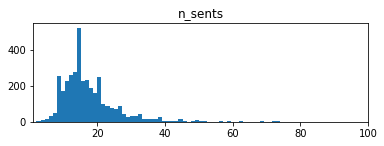

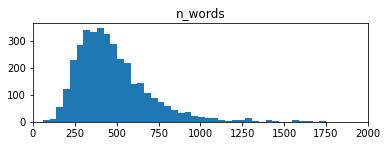

In [6]:
#@title Display data statistics
raw.head()
print(f'Number of document: {len(raw)}')

# count sentence in each document
count_sentences = lambda x: x.count('</s>')
raw['n_sents'] = raw['article'].map(count_sentences)

# count word in each docunent
count_words = lambda x: x.count(' ') + 1
raw['n_words'] = raw['article'].map(count_words)
 
# show data statistics
plt.subplot(2, 1, 1)
plt.xlim(1, 100)
plt.title('n_sents')
plt.hist(raw['n_sents'], bins=200)
plt.show()

plt.subplot(2, 1, 2)
plt.xlim(1, 2000)
plt.title('n_words')
plt.hist(raw['n_words'], bins=200)
plt.show()

In [0]:
#@title Save preprocessed data
if not os.path.exists(preprocessed_path):
    raw.to_csv(preprocessed_path)

## Construct a headline dataset

In [0]:
#@title Functions
def filter_sentences(doc, max_sents, max_tokens):
    sents = doc.lstrip('<s> ').rstrip(' </s>').split(' </s> <s>')
    while '' in sents:
        sents.pop(sents.index(''))

    if max_sents > 0:
        sents = sents[:max_sents] 
        count_words = lambda xs: sum([x.count(' ') + 1 for x in xs])
        n_words = count_words(sents)
        while n_words > max_tokens:
            max_sents -= 1
            sents = sents[:max_sents]
            n_words = count_words(sents)
        if n_words == 0:
            return None
    return ' '.join(sents)
    
def generate_dataset(df, max_sents=3, max_tokens=128):
    dataset = pd.DataFrame()
    dataset['article'] = df['article'].apply(filter_sentences, args=(max_sents, max_tokens, ))
    dataset['headline'] = df['headline'].map(lambda x: x.replace('<s>', '').replace('</s>', ''))
    dataset = dataset.dropna()
    
    dataset['n_words'] = dataset['article'].map(lambda x: x.count(' ') + 1)
    return dataset

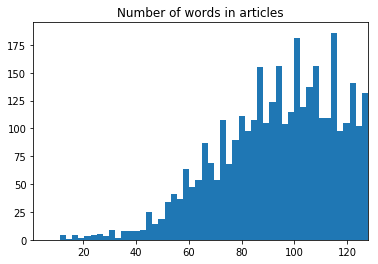

In [17]:
#@title Construct datasets
max_sents = 3 #@param {type: "number"}
min_tokens = 10 #@param {type: "number"}
max_tokens = 128 #@param {type: "number"}

max_tokens = max_tokens if max_sents > 0 else 2000

dataset = generate_dataset(
    raw,
    max_sents=max_sents,
    max_tokens=max_tokens
)

dataset = dataset[dataset['n_words'] > min_tokens]

plt.xlim(1, max_tokens)
plt.title('Number of words in articles')
plt.hist(dataset['n_words'], bins=50) 
plt.show()

In [0]:
#@title Save a dataset
dataset = dataset[['article', 'headline']]

savedir = '/content/drive/My Drive/wikinews-headline/'
filename = f'jwhd-s{max_sents}-w{max_tokens}.csv' if max_sents > 0 else 'jwhd-full-article.csv'
path = os.path.join(savedir, filename)
dataset.to_csv(path)

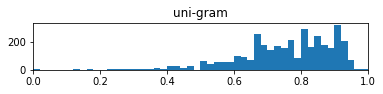

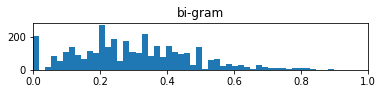

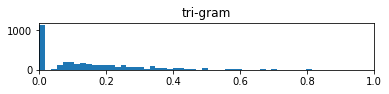

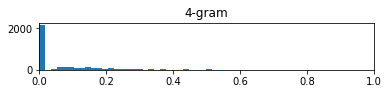

In [19]:
#@title Calculate n-gram overlap
def ngram_overlap(line, ngram):
    # from IPython.core.debugger import Pdb; Pdb().set_trace()
    src_ngram = list(nltk.ngrams(line['article'].split(' '), ngram))
    tgt_ngram = list(nltk.ngrams(line['headline'].split(' '), ngram))
    match_ngram = 0
    for ngram in tgt_ngram:
        if ngram in src_ngram:
            match_ngram += 1
    return match_ngram/len(tgt_ngram)


dataset['uni-gram'] = dataset.apply(ngram_overlap, axis=1, args=(1, ))
dataset['bi-gram'] = dataset.apply(ngram_overlap, axis=1, args=(2, ))
dataset['tri-gram'] = dataset.apply(ngram_overlap, axis=1, args=(3, ))
dataset['4-gram'] = dataset.apply(ngram_overlap, axis=1, args=(4, ))


# show data statistics
plt.subplot(4, 1, 1)
plt.xlim(0.0, 1.0)
plt.title('uni-gram')
plt.hist(dataset['uni-gram'], bins=50)
plt.show()

plt.subplot(4, 1, 2)
plt.xlim(0.0, 1.0)
plt.title('bi-gram')
plt.hist(dataset['bi-gram'], bins=50)
plt.show()

plt.subplot(4, 1, 3)
plt.xlim(0.0, 1.0)
plt.title('tri-gram')
plt.hist(dataset['tri-gram'], bins=50)
plt.show()

plt.subplot(4, 1, 4)
plt.xlim(0.0, 1.0)
plt.title('4-gram')
plt.hist(dataset['4-gram'], bins=50)
plt.show()


In [20]:
print(f"uni-gram: {dataset['uni-gram'].mean()*100:.4}%")
print(f"bi-gram: {dataset['bi-gram'].mean()*100:.4}%")
print(f"tri-gram: {dataset['tri-gram'].mean()*100:.4}%")
print(f"4-gram: {dataset['4-gram'].mean()*100:.4}%")

uni-gram: 75.51%
bi-gram: 29.82%
tri-gram: 15.05%
4-gram: 7.823%
